<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Итоги-работы" data-toc-modified-id="Итоги-работы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги работы</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание проекта

В рамках проекта дан датафрейм с информацией о клиентах банка - индивидуальные номера, фамилии, кредитный рейтинг, страна, пол, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, наличие кредитной карты, активность использования банковских услуг, ориентировочная зарплата, а также кодированные данные, отражающие факт прекращения пользования банковскими услугами. Цель - обучить модель, предсказывающую отток клиентов (прекращение пользования услугами банка) с наивысшей метрикой F1 не ниже 0.59.

Для достижения цели предусмотрены следующие задачи: 1) подготовка данных (информация о датафрейме, его содержимом, корреляциях количественных значений, наличии дубликатов и пропусков, определение целевого признака и дисбаланса); 2) исследование задачи (определение обучающей, валидационной и тестовой выборок, обучение альфа-версий моделей без корректиировки дисбаланса, проверка моделей на вменяемость); 3) борьба с дисбалансом (применение ряда методов для устранения дисбаланса, обновление обучающей, валидационной и тестовой выборок, улучшение моделей, проверка моделей на вменяемость, опеределение наилучшей модели по метрике F1); 4) тестирование наилучшей модели на тестовой выборке несбалансированного (оригинального) датафрейма, сверка метрики F1 с контрольным значением, предусмотренным заданием.

## Подготовка данных

Импортируем библиотеки.

In [68]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer

from tqdm import tqdm
from sklearn.utils import shuffle
from joblib import dump
from joblib import load


Изучим заданный датафрейм.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.shape)
display(data[:5])
data.info()
data.isnull().sum()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Датафрейм состоит из 14 столбцов и 10000 строк. Каждая строка обозначает уникального клиента банка. Столбцы обозначают: порядковый номер объекта, уникальный номер клиента, фамилию, кредитный рейтинг, страну, пол, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, наличие кредитной карты (кодировано через 0 и 1), активность использования банковских услуг (кодировано через 0 и 1), ориентировочная зарплата, а также данные, отражающие факт прекращения пользования банковскими услугами (кодировано через 0 и 1).

Качественные данные: порядковый номер, уникальный номер, фамилия, страна, пол, наличие кредитной карты, активность использования банковских услуг, данные, отражающие факт прекращения пользования банковскими услугами.

Количественные данные: кредитный рейтинг, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, ориентировочная зарплата.

В каждом столбце, кроме срока обслуживания - по 10000 значений. В столбце срока обслуживания обнаружено 909 пропусков.

Уникальный признак для каждого объекта в датафрейме - идентификационный номер. По нему проверим наличиие дубликатов.

In [3]:
print(data.duplicated(subset='CustomerId').value_counts())

False    10000
dtype: int64


Дубликаты не обнаружены.

Теперь проверим количественные величины на наличие выбросов.

Графики размаха для количественных величин датафрейма


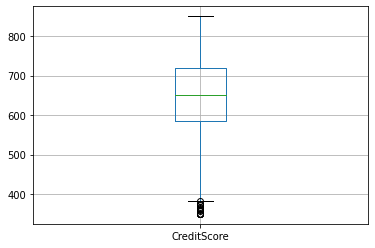

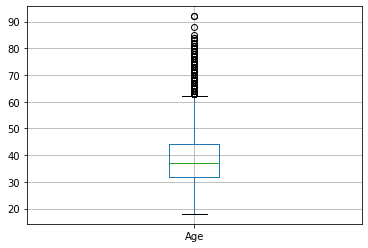

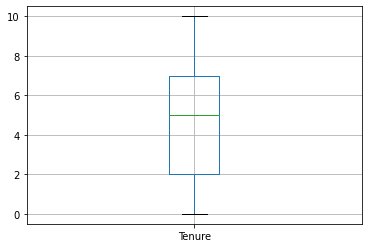

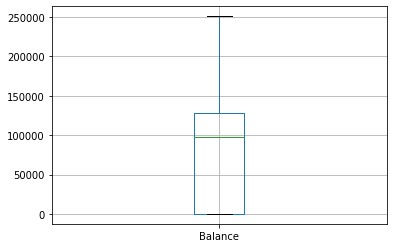

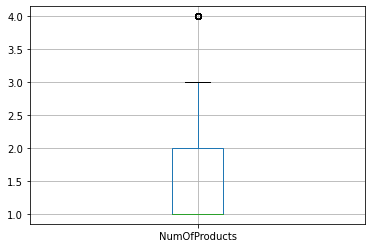

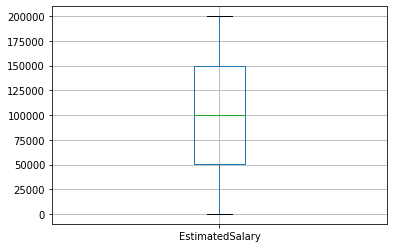

In [4]:
numeric = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
print('Графики размаха для количественных величин датафрейма')
for i in numeric:
    data.boxplot(column=[i])
    plt.show()

Неправдоподобных выбросов в количественных данных не обнаружено.

Проверим значения кодированных качественных величин - в каждом столбце должны быть только значения 0 и/или 1.

In [5]:
coded = data[['HasCrCard', 'IsActiveMember', 'Exited']]
for i in coded:
    print(data[i].value_counts())

1    7055
0    2945
Name: HasCrCard, dtype: int64
1    5151
0    4849
Name: IsActiveMember, dtype: int64
0    7963
1    2037
Name: Exited, dtype: int64


В столбцах с кодированными величинами необычных значений не обнаружено.

Для обучения моделей столбцы с порядковым номером, уникальным номером клиента и фамилией значения не представляют, от них можно избавиться.

In [6]:
data = data.drop(labels=['RowNumber','CustomerId','Surname'], axis=1)

Для профилактики мультиколлинеарности проверим корреляцию признаков датафрейма на матрице. Пороговым значением обозначим корреляцию 0.5.

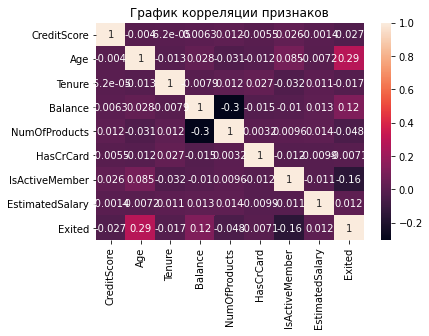

In [7]:
corr_matrix = data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.title('График корреляции признаков')
plt.show()

Значительной корреляции между признаками не обнаружено.

Преобразуем строчные данные в числовые с применением OneHotEncoder-кодирования, предотвращая dummy-ловушку.

In [8]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), ['Geography','Gender']),
    remainder='passthrough')

data_transformed = transformer.fit_transform(data)
data = pd.DataFrame(
    data_transformed, 
    columns=transformer.get_feature_names()
)

Избавимся от пропусков в столбце со сроком обслуживания в банке. Удаление строк с отсутствующими данными привело бы к существенной потере информации.

Для заполнения пропусков в столбце с количественными показателями обучим модели-регрессоры и сравним их метрики среднего абсолютного отклонения с dummy-моделью, заполняющей пропуски медианным значением. Если метрика модели-регрессора будет выше метрики dummy-модели, для заполнения используем предсказания модели-регрессора, если ниже - используем заполнение пропусков медианой.

In [9]:
df_1 = data.copy()

In [10]:
tenure_0 = df_1.loc[df_1['Tenure'].isna()==True]
tenure_1 = df_1.loc[df_1['Tenure'].isna()==False]
features_0 = tenure_0.drop(labels='Tenure', axis=1)
target_0 = tenure_0['Tenure']
features_1 = tenure_1.drop(labels='Tenure', axis=1)
target_1 = tenure_1['Tenure']

In [11]:
features_1_train, features_1_valid, target_1_train, target_1_valid = \
train_test_split(
    features_1, target_1, test_size=0.25,
    random_state=12345, stratify=target_1)
print(features_1_train.shape)
print(target_1_train.shape)

print(features_1_valid.shape)
print(target_1_valid.shape)

(6818, 11)
(6818,)
(2273, 11)
(2273,)


In [12]:
predictions_constant = pd.Series(target_1_train.median(),
                                 index = target_1_valid.index)
mae_constant = mean_absolute_error(target_1_valid, predictions_constant)
print(mae_constant)

2.48614166300044


In [13]:
best_mae = mae_constant
for splitter_value in ['best', 'random']:
    for min_samples_leaf_value in tqdm(range(1,10,1)):
        for depth in range(1,20,1):
            model = DecisionTreeRegressor(
                splitter=splitter_value,
                min_samples_leaf=min_samples_leaf_value,
                max_depth=depth, random_state=12345
            )
            model.fit(features_1_train, target_1_train)
            predictions_valid = model.predict(features_1_valid)
            mae_valid = mean_absolute_error(target_1_valid,
                                            predictions_valid)
            if mae_valid <= best_mae:
                best_mae = mae_valid
                best_depth = depth
                print('Значение гиперпараметра максимальной глубины:',\
                      best_depth)
            else:
                pass

100%|██████████| 9/9 [00:01<00:00,  7.53it/s]


In [14]:
best_mae = mae_constant
for depth in tqdm(range(1,20,1)):
    for estimator in range(1,20,1):
        model = RandomForestRegressor(
            max_depth=depth,
            n_estimators=estimator,
            random_state=12345
        )
        model.fit(features_1_train, target_1_train)
        predictions_valid = model.predict(features_1_valid)
        mae_valid = mean_absolute_error(target_1_valid, predictions_valid)
        if mae_valid <= best_mae:
            best_mae = mae_valid
            best_depth = depth
            print('Значение гиперпараметра максимальной глубины:', best_depth)
        else:
            pass

100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Ни одна из моделей не показала метрику выше, чем у dummy-модели. Заполняем пропуски медианой.

In [15]:
data['Tenure'] = data['Tenure'].fillna(value=data['Tenure'].median())

In [16]:
data.isnull().sum()

onehotencoder__x0_Germany    0
onehotencoder__x0_Spain      0
onehotencoder__x1_Male       0
CreditScore                  0
Age                          0
Tenure                       0
Balance                      0
NumOfProducts                0
HasCrCard                    0
IsActiveMember               0
EstimatedSalary              0
Exited                       0
dtype: int64

Больше пропусков в датафрейме не осталось.

Зададим целевой признак - информацию о прекращении пользования услугами банка. Целевой признак - качественный, соответственно, мы будем обучать модели-классификаторы.

In [17]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

Исследуем дисбаланс по целевому признаку.

In [18]:
print(target.value_counts(normalize=True))

0.0    0.7963
1.0    0.2037
Name: Exited, dtype: float64


Почти в 80 процентах объектов значение целевого признака равно 0 - это серьёзный дисбаланс.

Подведём промежуточные итоги.

Датафрейм состоит из 14 столбцов и 10000 строк. Каждая строка обозначает уникального клиента банка. Столбцы обозначают: порядковый номер объекта, уникальный номер клиента, фамилию, кредитный рейтинг, страну, пол, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, наличие кредитной карты (кодировано через 0 и 1), активность использования банковских услуг (кодировано через 0 и 1), ориентировочная зарплата, а также данные, отражающие факт прекращения пользования банковскими услугами (кодировано через 0 и 1).

Качественные данные: порядковый номер, уникальный номер, фамилия, страна, пол, наличие кредитной карты, активность использования банковских услуг, данные, отражающие факт прекращения пользования банковскими услугами. В столбцах с кодированными величинами необычных значений не обнаружено.

Количественные данные: кредитный рейтинг, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, ориентировочная зарплата. Неправдоподобных выбросов в количественных данных не обнаружено. Строчные данные преобразованы в числовые с применением dummy-кодирования во избежание dummy-ловушки.

В каждом столбце, кроме срока обслуживания - по 10000 значений. В столбце срока обслуживания обнаружено 909 пропусков. Пропуски заполнены медианным значением.

Значительной корреляции между признаками не обнаружено.

Задан целевой признак - информация о прекращении пользования услугами банка. Целевой признак - качественный, соответственно, мы будем обучать модели-классификаторы. Почти в 80 процентах объектов значение целевого признака равно 0 - это серьёзный дисбаланс.

## Исследование задачи

Создадим обучающую, валидационную и тестовую выборки.

In [19]:
features_train_valid, features_test = train_test_split(features, test_size=0.2, random_state=12345)
features_train, features_valid = train_test_split(features_train_valid, test_size=0.25, random_state=12345)
target_train_valid, target_test = train_test_split(target, test_size=0.2, random_state=12345)
target_train, target_valid = train_test_split(target_train_valid, test_size=0.25, random_state=12345)

Создадим функцию для построения кривой метрики ROC, вычисления метрики AUC-ROC и сравнения её с метрикой F1.

In [20]:
def roc_f1 (model, features_valid, target_valid, result):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')

    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    plt.show()
    print('Значение AUC-ROC:', auc_roc)
    if auc_roc > f1_score(target_valid, predictions):
        print('Метрика AUC-ROC больше метрики F1 на', auc_roc-result)
    if auc_roc == f1_score(target_valid, predictions):
        print('Метрика AUC-ROC равна метрике F1')
    if auc_roc < f1_score(target_valid, predictions):
        print('Метрика AUC-ROC меньше метрики F1 на', abs(auc_roc-result))

Создаём dummy-модель для проверки альфа-версий моделей-классификаторов. Стратегия формирования величин - по константному значению наименьшего класса, поскольку иначе на нулевых значениях метрика F1 тоже будет равен нулю.

Метрика F1 для dummy-модели: 0.32705980761187786


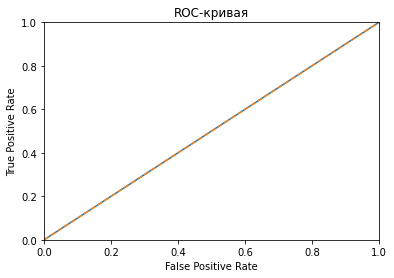

Значение AUC-ROC: 0.5
Метрика AUC-ROC больше метрики F1 на 0.17294019238812214
None


In [21]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(features_train, target_train)
predictions = dummy_clf.predict(features_valid)
result = f1_score(target_valid, predictions)
print('Метрика F1 для dummy-модели:', result)

print(roc_f1(dummy_clf, features_valid, target_valid, result))

Обучим три модели-классификатора - модель решающего дерева, модель случайного леса, модель логистической регрессии - зафиксируем метрики F1 и AUC-ROC и сохраним модели. Каждую модель проверяем на вменяемость, сравнивая метрики с dummy-моделью.

100%|██████████| 99/99 [00:02<00:00, 36.21it/s]


Метрика F1 для наилучшей модели решающего дерева: 0.5583596214511041
Значение гиперпараметра максимальной глубины дерева max_depth: 7


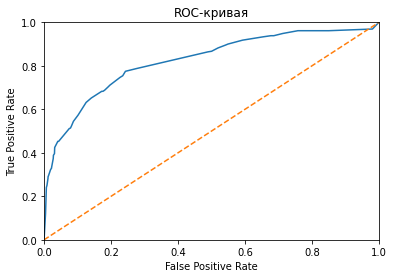

Значение AUC-ROC: 0.8231010349393358
Метрика AUC-ROC больше метрики F1 на 0.26474141348823177
None


In [22]:
not_best_model_1 = None
best_result = 0
for depth in tqdm(range(1, 30)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        not_best_model_1 = model
        best_result = result
        best_max_depth = depth
print ('Метрика F1 для наилучшей модели решающего дерева:', best_result)
print ('Значение гиперпараметра максимальной глубины дерева max_depth:', best_max_depth)
print(roc_f1(not_best_model_1, features_valid, target_valid, best_result))

In [23]:
dump(not_best_model_1, 'model_1a.joblib')

['model_1a.joblib']

100%|██████████| 49/49 [03:08<00:00,  3.84s/it]

Метрика F1 для наилучшей модели случайного леса: 0.5788667687595712
Значение гиперпараметра количества деревьев в лесу: 17
Значение гиперпараметра максимальной глубины дерева: 23


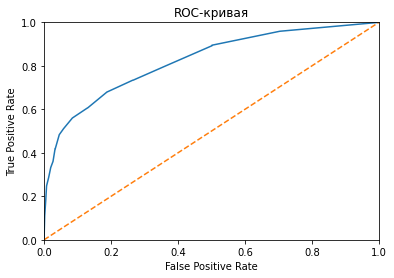

Значение AUC-ROC: 0.8237598928024745
Метрика AUC-ROC больше метрики F1 на 0.2448931240429033
None


In [24]:
not_best_model_2 = None
best_result = 0
for est in tqdm(range(1, 30)):
    for depth in (range (1,30)):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            not_best_model_2 = model
            best_result = result
            best_n_estimators = est
            best_max_depth = depth
print ('Метрика F1 для наилучшей модели случайного леса:', best_result)
print ('Значение гиперпараметра количества деревьев в лесу:', best_n_estimators)
print ('Значение гиперпараметра максимальной глубины дерева:', best_max_depth)
print(roc_f1(not_best_model_2, features_valid, target_valid, best_result))

In [25]:
dump(not_best_model_2, 'model_2a.joblib')

['model_2a.joblib']

100%|██████████| 900/900 [02:43<00:00,  5.51it/s]


Метрика F1 для наилучшей модели логистической регрессии: 0.10290827740492169
Значение гиперпараметра максимального количества итераций max_iter: 100


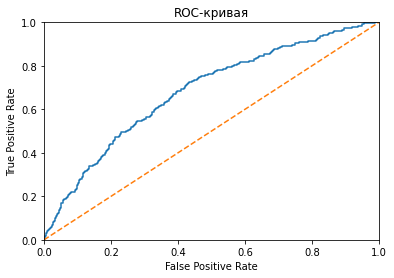

Значение AUC-ROC: 0.6813607600469863
Метрика AUC-ROC больше метрики F1 на 0.5784524826420646
None


In [26]:
not_best_model_3 = None
best_result = 0
for i in tqdm(range(100,1000)):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        not_best_model_3 = model
        best_result = result
        best_max_iter = i
    
print ('Метрика F1 для наилучшей модели логистической регрессии:', best_result)
print ('Значение гиперпараметра максимального количества итераций max_iter:', best_max_iter)
print(roc_f1(not_best_model_3, features_valid, target_valid, best_result))

Модель логистической регрессии демонстрирует метрику F1 ниже dummy-модели.

In [27]:
dump(not_best_model_3, 'model_3a.joblib')

['model_3a.joblib']

Подведём промежуточные итоги.

При условии сохранения дисбаланса объектов по целевому признаку модель, демонстрирующая наивысшие метрики F1 и AUC-ROC - модель случайного леса со значениями гиперпараметров максимальной глубины дерева 23 и количества деревьев 17 с метриками F1 0.5788667687595712 и AUC-ROC 0.8237598928024745.

Метрика F1 для данной модели, однако, не превышает установленный заданием минимальный порог в 0.59. Для повышения метрик улучшим модели, обучив их на сбалансированных признаков.

## Борьба с дисбалансом

Для компенсации дисбаланса последовательно применим два метода: масштабирование признаков и upscaling.

Создаеём копию датафрейма, обозначаем признаки и целевой признак.

In [49]:
df_2 = data.copy()

In [50]:
features_2 = df_2.drop(['Exited'], axis=1)
target_2 = df_2['Exited']

Создаём обучающую и валидационную выборки с учётом соотношения классов.

In [51]:
features_2_train, features_2_valid, target_2_train, target_2_valid = \
train_test_split(
    features_2, target_2,
    test_size=0.25, stratify=target_2, random_state=12345
)

Масштабируем количественные признаки.

In [52]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',
           'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_2_train[numeric])
features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])

/tmp/ipykernel_48/3392945019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_2_train[numeric] = scaler.transform(features_2_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Теперь выравниваем баланс классов в выборках с помощью метода upscaling.

In [53]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + \
                                   [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )
    
    return features_upsampled, target_upsampled

In [54]:
features_upsampled, target_upsampled = upsample(
    features_2, target_2, 4
)

In [55]:
print(target_upsampled.value_counts(normalize=True))

1.0    0.505741
0.0    0.494259
Name: Exited, dtype: float64


Обновим обучающую и валидационную тестовую выборки.

In [56]:
features_upsampled_train, features_upsampled_valid, target_upsampled_train,\
target_upsampled_valid = train_test_split(
    features_upsampled, target_upsampled,
    test_size=0.25, stratify=target_upsampled, random_state=12345
)

В результате применения методов масштабирования и upscaling значения признаков сбалансированы.

Обновим dummy-модель на новых выборках.

Метрика F1 для dummy-модели: 0.6717230008244023


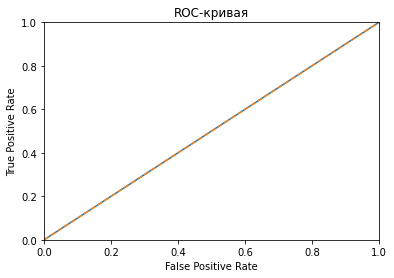

Значение AUC-ROC: 0.5
Метрика AUC-ROC меньше метрики F1 на 0.17172300082440228
None


In [57]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(features_upsampled_train, target_upsampled_train)
predictions = dummy_clf.predict(features_upsampled_valid)
result = f1_score(target_upsampled_valid, predictions)
print('Метрика F1 для dummy-модели:', result)
print(roc_f1(dummy_clf, features_upsampled_valid, target_upsampled_valid, result))

Обучим модели-классификаторы на обновлённых выборках. Зафиксируем метрики F1 и AUC-ROC и сохраним модели. Каждую модель проверяем на вменяемость, сравнивая метрики с dummy-моделью.

100%|██████████| 99/99 [00:05<00:00, 19.16it/s]


Метрика F1 для наилучшей модели решающего дерева: 0.9273844753016163
Значение гиперпараметра максимальной глубины дерева max_depth: 25


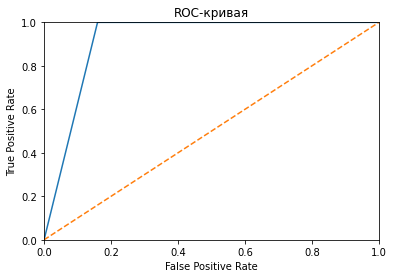

Значение AUC-ROC: 0.9201557968146793
Метрика AUC-ROC меньше метрики F1 на 0.007228678486936979
None


In [58]:
best_model_1 = None
best_result = 0
for depth in tqdm(range(1, 30)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled_train, target_upsampled_train)
    predictions = model.predict(features_upsampled_valid)
    result = f1_score(target_upsampled_valid, predictions)
    if result > best_result:
        best_model_1 = model
        best_result = result
        best_max_depth = depth
print ('Метрика F1 для наилучшей модели решающего дерева:', best_result)
print ('Значение гиперпараметра максимальной глубины дерева max_depth:', best_max_depth)
print(roc_f1(best_model_1, features_upsampled_valid, target_upsampled_valid, best_result))

In [59]:
dump(best_model_1, 'model_1.joblib')

['model_1.joblib']

100%|██████████| 59/59 [14:01<00:00, 14.26s/it]

Метрика F1 для наилучшей модели случайного леса: 0.9552168815943728
Значение гиперпараметра количества деревьев в лесу: 44
Значение гиперпараметра максимальной глубины дерева: 24


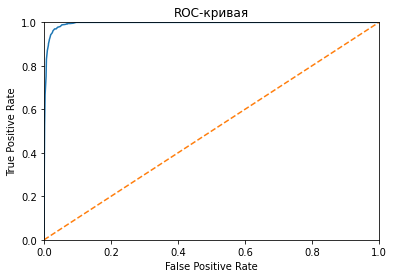

Значение AUC-ROC: 0.9947021044873754
Метрика AUC-ROC больше метрики F1 на 0.0394852228930026
None


In [60]:
best_model_2 = None
best_result = 0
for est in tqdm(range(1, 50)):
    for depth in (range (1,50)):
        model = RandomForestClassifier(
            random_state=12345, n_estimators=est, max_depth=depth
        )
        model.fit(features_upsampled_train, target_upsampled_train)
        predictions = model.predict(features_upsampled_valid)
        result = f1_score(target_upsampled_valid, predictions)
        if result > best_result:
            best_model_2 = model
            best_result = result
            best_n_estimators = est
            best_max_depth = depth
print ('Метрика F1 для наилучшей модели случайного леса:', best_result)
print ('Значение гиперпараметра количества деревьев в лесу:', best_n_estimators)
print ('Значение гиперпараметра максимальной глубины дерева:', best_max_depth)
print(roc_f1(best_model_2, features_upsampled_valid, target_upsampled_valid, best_result))

In [61]:
dump(best_model_2, 'model_2.joblib')

['model_2.joblib']

100%|██████████| 900/900 [02:59<00:00,  5.00it/s]


Метрика F1 для наилучшей модели логистической регрессии: 0.6730493058879846
Значение гиперпараметра максимального количества итераций max_iter: 100


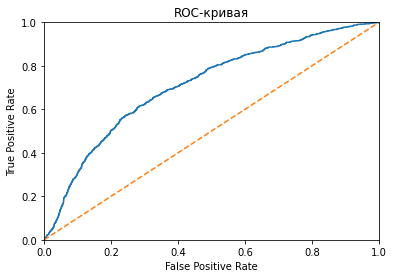

Значение AUC-ROC: 0.7104197657253418
Метрика AUC-ROC больше метрики F1 на 0.037370459837357206
None


In [62]:
best_model_3 = None
best_result = 0
for i in tqdm(range(100,1000)):
    model = LogisticRegression(
        random_state=12345, solver='liblinear', max_iter=i
    )
    model.fit(features_upsampled_train, target_upsampled_train)
    predictions = model.predict(features_upsampled_valid)
    result = f1_score(target_upsampled_valid, predictions)
    if result > best_result:
        best_model_3 = model
        best_result = result
        best_max_iter = i    
print ('Метрика F1 для наилучшей модели логистической регрессии:', best_result)
print ('Значение гиперпараметра максимального количества итераций max_iter:',\
       best_max_iter)
print(roc_f1(best_model_3, features_upsampled_valid, target_upsampled_valid, best_result))

In [63]:
dump(best_model_3, 'model_3.joblib')

['model_3.joblib']

Подведём промежуточные итоги.

После корректировки дисбаланса объектов по целевому признаку методами upscaling и масштабирования метрики моделей повысились - это наглядно демонстрируют увеличившиеся углы линий графиков ROC.

Модель, демонстрирующая наивысшие метрики F1 и AUC-ROC - случайный лес со значениями гиперпараметров максимальной глубины дерева 24 и количества деревьев 44 с метриками F1 0.9552168815943728 и AUC-ROC 0.9947021044873754.

Метрика F1 для данной модели превышает установленный заданием минимальный порог в 0.59.

## Тестирование модели

Обновим dummy-модель на тестовой выборке.

Метрика F1 для dummy-модели: 0.3381803074366431


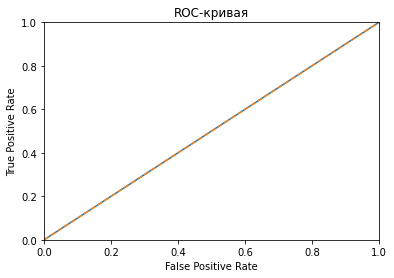

Значение AUC-ROC: 0.5
Метрика AUC-ROC больше метрики F1 на 0.16181969256335688
None


In [64]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(features_test, target_test)
predictions = dummy_clf.predict(features_test)
result = f1_score(target_test, predictions)
print('Метрика F1 для dummy-модели:', result)
print(roc_f1(dummy_clf, features_test, target_test, result))

Протестируем модель случайного леса на оптимальных гиперпараметрах на тестовой выборук и зафиксируем метрики F1 и AUC-ROC.

In [65]:
model_2 = load('model_2.joblib')

Метрика F1 для наилучшей модели случайного леса: 0.9454123112659698


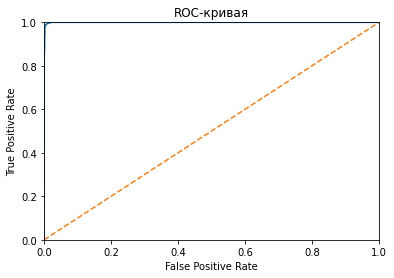

Значение AUC-ROC: 0.999193338176389
Метрика AUC-ROC больше метрики F1 на 0.053781026910419194
None


In [66]:
predictions = model_2.predict(features_test)
result = f1_score(target_test, predictions)
print ('Метрика F1 для наилучшей модели случайного леса:', result)
print(roc_f1(model_2, features_test, target_test, result))

По результатам тестирования модель случайного леса на гиперпараметрах максимальной глубины 24 и количества деревьев 44 продемонстрировала метрики F1 0.9454123112659698 и AUC-ROC 0.999193338176389. Метрика F1 для данной модели превышает установленный заданием минимальный порог в 0.59. Вменяемость модели проверена.

## Итоги работы

Заданный датафрейм состоит из 14 столбцов и 10000 строк. Каждая строка обозначает уникального клиента банка. Столбцы обозначают: порядковый номер объекта, уникальный номер клиента, фамилию, кредитный рейтинг, страну, пол, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, наличие кредитной карты (кодировано через 0 и 1), активность использования банковских услуг (кодировано через 0 и 1), ориентировочная зарплата, а также данные, отражающие факт прекращения пользования банковскими услугами (кодировано через 0 и 1).

Качественные данные: порядковый номер, уникальный номер, фамилия, страна, пол, наличие кредитной карты, активность использования банковских услуг, данные, отражающие факт прекращения пользования банковскими услугами. В столбцах с кодированными величинами необычных значений не обнаружено.

Количественные данные: кредитный рейтинг, возраст, срок обслуживания в банке, баланс на счёте, количество используемых банковских продуктов, ориентировочная зарплата. Неправдоподобных выбросов в количественных данных не обнаружено. Строчные данные преобразованы в числовые с применением dummy-кодирования во избежание dummy-ловушки.

В каждом столбце, кроме срока обслуживания - по 10000 значений. В столбце срока обслуживания обнаружено 909 пропусков. Пропуски заполнены медианным значением.

Значительной корреляции между признаками не обнаружено, мультиколлинеарность исключена.

Задан целевой признак - информация о прекращении пользования услугами банка. Целевой признак - качественный, соответственно, мы будем обучать модели-классификаторы. Почти в 80 процентах объектов значение целевого признака равно 0 - это серьёзный дисбаланс.

При условии сохранения дисбаланса объектов по целевому признаку модель, демонстрирующая наивысшие метрики F1 и AUC-ROC - модель случайного леса со значениями гиперпараметров максимальной глубины дерева 23 и количества деревьев 17 с метриками F1 0.5788667687595712 и AUC-ROC 0.8237598928024745. После корректировки дисбаланса объектов по целевому признаку методами upscaling и масштабирования метрики моделей повысились - это наглядно демонстрируют увеличившиеся углы линий графиков ROC. Модель, демонстрирующая наивысшие метрики F1 и AUC-ROC - также случайный лес со значениями гиперпараметров максимальной глубины дерева 24 и количества деревьев 44 с метриками F1 0.9552168815943728 и AUC-ROC 0.9947021044873754.

По результатам тестирования модель случайного леса на гиперпараметрах максимальной глубины 24 и количества деревьев 44 продемонстрировала метрики F1 0.9454123112659698 и AUC-ROC 0.999193338176389. Метрика F1 для данной модели превышает установленный заданием минимальный порог в 0.59. Вменяемость модели проверена.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*